In [2]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Setting a time limit for optimization (in seconds)
time_limit = 3600

### Data Pre-processing

In [12]:
# Reading the training and test datasets from CSV files
train_set = pd.read_csv('training_data.csv')
test_set = pd.read_csv('test_data.csv')

# Extracting features (X) and target variable (Y) from the training set
X_train = train_set.drop(columns='y')  # Features
Y_train = train_set['y']  # Target variable

# Extracting features (X) and target variable (Y) from the test set
X_test = test_set.drop(columns='y')  # Features
Y_test = test_set['y']  # Target variable


In [13]:
# Number of samples in the training set
n = len(X_train)

# Number of features in the training set
m = X_train.shape[1]

### Lasso Regression and Cross Validation

In [14]:
# Importing necessary libraries
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Initializing the StandardScaler
scaler = StandardScaler()

# Scaling the features in the training set
X_train_sc = scaler.fit_transform(X_train)

# Scaling the features in the test set using the parameters learned from the training set
X_test_sc = scaler.transform(X_test)

In [16]:
# Initializing LassoCV model with 10-fold cross-validation, random state, and maximum iterations
lasso = LassoCV(cv=10, random_state=15, max_iter=10000)

# Fitting the Lasso model to the scaled training data
lasso.fit(X_train_sc, Y_train)

# Extracting the optimal alpha (regularization strength) chosen by cross-validation
lasso_alpha = lasso.alpha_

In [17]:
# Making predictions on the test set using the trained Lasso model
y_pred = lasso.predict(X_test_sc)

# Calculating the Sum of Squared Errors (SSE) on the test set
sse_test = np.sum((Y_test - y_pred) ** 2)

# Printing the SSE on the test set
print(f"SSE on the test set: {sse_test}")

SSE on the test set: 117.83331916077934


The initial phase of the study concentrated on evaluating the efficacy of the LASSO Regression method, a technique commonly utilized within the organization. To identify the most appropriate lambda value for the training dataset, a 10-fold cross-validation approach was adopted. This methodological procedure facilitated the determination of an optimal lambda value, which was found to be 0.085. Subsequent to the model being adjusted to fit the training data, its predictive accuracy was assessed using the test dataset. This evaluation resulted in a Sum of Squared Errors (SSE) amounting to 117.833, indicating the model's performance in terms of prediction accuracy.

In [18]:
# Extracting selected features based on non-zero coefficients from the Lasso model
selected_features = X_train.columns[lasso.coef_ != 0]

# Extracting corresponding coefficients for the selected features
coefficients = lasso.coef_[lasso.coef_ != 0]

# Displaying the selected features and their corresponding coefficients
print("Selected features:")
print(selected_features)
print("Corresponding coefficients:")
print(coefficients)

Selected features:
Index(['X9', 'X11', 'X15', 'X16', 'X22', 'X23', 'X24', 'X26', 'X29', 'X33',
       'X34', 'X35', 'X39', 'X44', 'X45', 'X46', 'X47', 'X48'],
      dtype='object')
Corresponding coefficients:
[-2.71982685 -0.05745334 -0.39585533 -0.23276644 -0.22180365 -1.15847952
  0.77569425 -1.27950133  0.06530332 -0.10847216  0.25740072  0.01277731
 -0.18839793  0.0186891   1.63196351 -0.01838965  0.69384574 -0.08473514]


In [19]:
# Creating a DataFrame with selected features and their corresponding coefficients
df = pd.DataFrame({'Selected Features': selected_features, 'Coefficients': coefficients})

# Displaying the DataFrame
df

,Selected Features,Coefficients
0,X9,-2.719827
1,X11,-0.057453
2,X15,-0.395855
3,X16,-0.232766
4,X22,-0.221804
5,X23,-1.158480
6,X24,0.775694
7,X26,-1.279501
8,X29,0.065303
9,X33,-0.108472


It is important to note that the LASSO Regularization method reduces the coefficients of the features that have very low influence to zero and this resulted in a refined set of 18 features selected from the training dataset, emphasizing the model's capacity to recognize and prioritize influential variables.

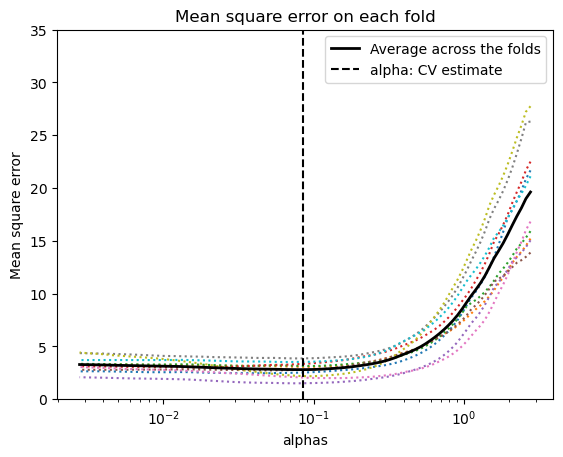

In [20]:
# Plotting the Mean Square Error (MSE) on each fold for different alpha values
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

# Adding labels, legend, and title to the plot
plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# Setting the y-axis limits
ymin, ymax = 0, 35
plt.ylim(ymin, ymax);

To improve the clarity and understanding of our analysis, a graph was generated to display the Mean Squared Error (MSE) for each fold against a series of lambda values. This visual representation not only detailed the MSE for each individual fold but also emphasized the average MSE computed across all folds. A vertical dashed line was included in the plot to signify the alpha value selected via cross-validation. This line serves as a graphical indicator of the optimal regularization strength, offering a clear point of reference for evaluating the effectiveness of the regularization parameter chosen.

### Using MIQP to Solve this problem

In [40]:
# List of k values to iterate through
k_list = list(range(5, 51, 5))
# Number of folds for cross-validation
n_folds = 10
# Set the value for M in the MIQP model
M = 500 
# Calculate the number of rows per fold
row_per_fold = int(n/n_folds)
# Dictionary to store SSE values for different k
k_error = {}

# Iterate through each k value
for k in k_list:
    total_sse = 0
    
    # Perform cross-validation for the current k value
    for _ in range(n_folds):
        # Randomly select indices for validation set without replacement
        val_ind = np.random.choice(len(X_train), size=int(len(X_train) / n_folds), replace=False)
        train_ind = np.setdiff1d(np.arange(len(X_train)), val_ind)
        
        # Create training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_ind,:], X_train.iloc[val_ind,:]
        y_train_fold, y_val_fold = Y_train[train_ind], Y_train[val_ind]

        # Create and solve the MIQP model
        qp = gp.Model()
        beta = qp.addMVar(m+1,lb=-np.inf)
        z = qp.addMVar(m, vtype = 'B')
        qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i]) 
                                    * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(m)) - y_train_fold.iloc[i])
                                     for i in range(len(X_train_fold))))

        con1 = qp.addConstr(gp.quicksum(z[j] for j in range(m)) <= k )
        con2 = qp.addConstrs(beta[j+1] <= M*z[j] for j in range(m))
        con3 = qp.addConstrs(beta[j+1] >= -M*z[j] for j in range(m))

        qp.Params.OutputFlag = 0
        qp.setParam('TimeLimit', time_limit)
        qp.optimize()
        
        # Compute the validation set error
        val_error = 0
        opt_beta = list(beta.x)
        for i in range(len(X_val_fold)):
            inner_sum = 0
            for j in range(m):
                inner_sum += opt_beta[j + 1] * X_val_fold.iloc[i, j]
    
            val_error += ((opt_beta[0] + inner_sum) - y_val_fold.iloc[i])*((opt_beta[0] + inner_sum) - y_val_fold.iloc[i])
        
        # Print the validation set error for the current k value
        print(val_error)
        total_sse += val_error
        
    # Calculate and print the average SSE on the validation set for the current k value
    print(f"SSE on validation set for k = {k} is {total_sse/n_folds}") 
    k_error[k] = total_sse/n_folds

74.53838731057333
101.730827850391
75.05353310427544
73.28567978101044
64.54295418106199
89.57871289804721
72.83442656640929
66.94570411926661
98.90701168659503
91.07051643041616
SSE on validation set for k = 5 is 80.84877539280465
57.675688778284865
63.60761868644668
57.748539163593655
76.46625396299423
73.53084536706388
51.393599192835445
41.06385487686306
72.72614606133952
60.107017957201826
65.36777518060372
SSE on validation set for k = 10 is 61.968733922722684
62.60370906997123
73.66409653125386
89.85750777386323
103.16050011195091
120.70538129549365
102.77951515903612
80.91672374677894
114.22498189285685
57.58844517677603
73.78542315643062
SSE on validation set for k = 15 is 87.92862839144115
61.04893867269771
111.11597018713837
68.96714752139611
61.80862123297185
121.18302574630462
92.32402578272671
76.77743511657408
85.07840718465636
64.27234536025072
90.20551176497642
SSE on validation set for k = 20 is 83.27814285696931
89.72097799746255
65.66531742458605
65.85903465842436
1

In the comparative analysis between LASSO Regression and a direct form of variable selection, the research focused on an optimization model designed to determine the optimal number of features (k) that would minimize the Sum of Squared Errors (SSE). This investigation necessitated a methodical division of the project into several phases to guarantee the accuracy of the findings.

The study commenced with the initial dataset comprising 50 features. The 'np.random.choice()' function from the numpy library in Python was employed to establish a validation framework, which partitioned the data into 10 folds. This setup facilitated the evaluation of the Mixed Integer Quadratic Programming (MIQP) model's performance over a range of k values. Notably, each cross-validation cycle entailed solving the model 10 times for each specified k value. A time constraint of 12 hours was imposed to prevent the optimization process from extending indefinitely.

To address the inclusion of both positive and negative coefficients in the model, the decision variables were assigned negative lower bounds. Furthermore, in the interest of maintaining the numerical stability of the model, a Big-M constraint value of 500 was deliberately chosen. This precaution was taken to circumvent the potential issue of coefficient values becoming equivalent to M, thus ensuring the reliability and stability of the model's computations.

In [41]:
import csv
csv_file_path = 'k_error.csv'

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Number of Features', 'Error'])
    for step, error in k_error.items():
        csv_writer.writerow([step, error])

In [21]:
# Read the CSV file containing k values and corresponding SSE errors
k_error = pd.read_csv('k_error.csv')

# Display the DataFrame with k values and SSE errors
k_error

,Number of Features,Error
0,5,80.848775
1,10,61.968734
2,15,87.928628
3,20,83.278143
4,25,80.481571
5,30,87.325916
6,35,85.079278
7,40,90.327595
8,45,84.405869
9,50,81.355476


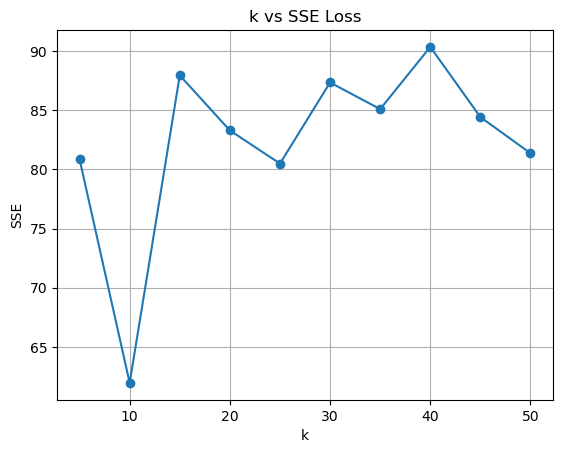

In [22]:
# Plotting the SSE loss for different values of k
plt.plot(k_error['Number of Features'], k_error['Error'], marker='o', linestyle='-')
plt.title('k vs SSE Loss')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

The optimization model identified k = 10 to be the optimal value that produced the lowest Sum of Squared Errors of 61.969. 

### Training the model on best k

In [23]:
# Find the row with the minimum error in the k_error DataFrame
min_k_row = k_error.loc[k_error['Error'].idxmin()]

# Extract the value of k with the minimum error
min_k = min_k_row['Number of Features']

In [24]:
# Define the parameters for the MIQP model
M = 500
qp = gp.Model()
beta = qp.addMVar(m + 1, lb=-np.inf)
z = qp.addMVar(m, vtype='B')

# Set the objective function for the MIQP model
qp.setObjective(gp.quicksum(
    (beta[0] + gp.quicksum(beta[j + 1] * X_train.iloc[i, j] for j in range(m)) - Y_train.iloc[i])
    * (beta[0] + gp.quicksum(beta[j + 1] * X_train.iloc[i, j] for j in range(m)) - Y_train.iloc[i])
    for i in range(len(X_train))))

# Add constraints to the MIQP model
con1 = qp.addConstr(gp.quicksum(z[j] for j in range(m)) <= min_k)
con2 = qp.addConstrs(beta[j + 1] <= M * z[j] for j in range(m))
con3 = qp.addConstrs(beta[j + 1] >= -M * z[j] for j in range(m))

# Set Gurobi parameters
qp.Params.OutputFlag = 0
qp.setParam('TimeLimit', time_limit)

# Optimize the MIQP model
qp.optimize()

# Extract the optimal values of beta
opt_beta = list(beta.x)

# Make predictions on the test set using the optimal beta values
y_pred_miqp = []
val_error = 0
for i in range(len(X_test)):
    inner_sum = 0
    for j in range(m):
        inner_sum += opt_beta[j + 1] * X_test.iloc[i, j]
    pred = inner_sum + opt_beta[0]
    y_pred_miqp.append(pred)
    val_error += (Y_test.iloc[i] - (opt_beta[0] + inner_sum)) * (Y_test.iloc[i] - (opt_beta[0] + inner_sum))

# Print the SSE on the test set for the selected k
print(f"SSE on test set for k = {min_k} is {val_error}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
SSE on test set for k = 10.0 is 116.8271982276263


The selected k value of 10 was used to fit the Mixed Integer Quadratic Programming (MIQP) model to the full training dataset. Using the β values derived from this fitted model, predictions were made on the test dataset. The performance of these predictions was assessed by calculating the Sum of Squared Errors (SSE). For the test set, the SSE was determined to be 116.827, which underscores the efficacy of the adopted approach for variable selection and model fitting.

### Identifying the selected features and coefficients using the MIQP model

In [25]:
# Get the indices of non-zero coefficients
non_zero_indices = [j for j in range(m) if opt_beta[j + 1] != 0]

# Get the names of the corresponding columns
selected_features_miqp = X_train.columns[non_zero_indices]

# Print the coefficients of the selected features for MIQP
coefficients_miqp = [opt_beta[j + 1] for j in range(m) if opt_beta[j + 1] != 0]

# Create a DataFrame with selected features and coefficients for MIQP
miqp_results_df = pd.DataFrame({'Selected Features': selected_features_miqp, 'Coefficients': coefficients_miqp})

# Display the DataFrame for MIQP results
print("MIQP Results:")
print(miqp_results_df)

MIQP Results:
  Selected Features  Coefficients
0                X9     -2.308207
1               X15     -0.518326
2               X16     -0.204162
3               X23     -1.559143
4               X24      0.866973
5               X26     -1.311919
6               X34      0.408165
7               X45      1.781475
8               X47      0.887383
9               X48     -0.282292


### Comparing the selected features and coefficients of the LASSO and MIQP models

In [26]:
# Merge the Lasso and MIQP DataFrames on 'Selected Features'
merged_df = pd.merge(df, miqp_results_df, how='outer', on='Selected Features', suffixes=('_LASSO', '_MIQP'))

# Display the merged DataFrame
print("Merged Results:")
print(merged_df)


Merged Results:
   Selected Features  Coefficients_LASSO  Coefficients_MIQP
0                 X9           -2.719827          -2.308207
1                X11           -0.057453                NaN
2                X15           -0.395855          -0.518326
3                X16           -0.232766          -0.204162
4                X22           -0.221804                NaN
5                X23           -1.158480          -1.559143
6                X24            0.775694           0.866973
7                X26           -1.279501          -1.311919
8                X29            0.065303                NaN
9                X33           -0.108472                NaN
10               X34            0.257401           0.408165
11               X35            0.012777                NaN
12               X39           -0.188398                NaN
13               X44            0.018689                NaN
14               X45            1.631964           1.781475
15               X46    

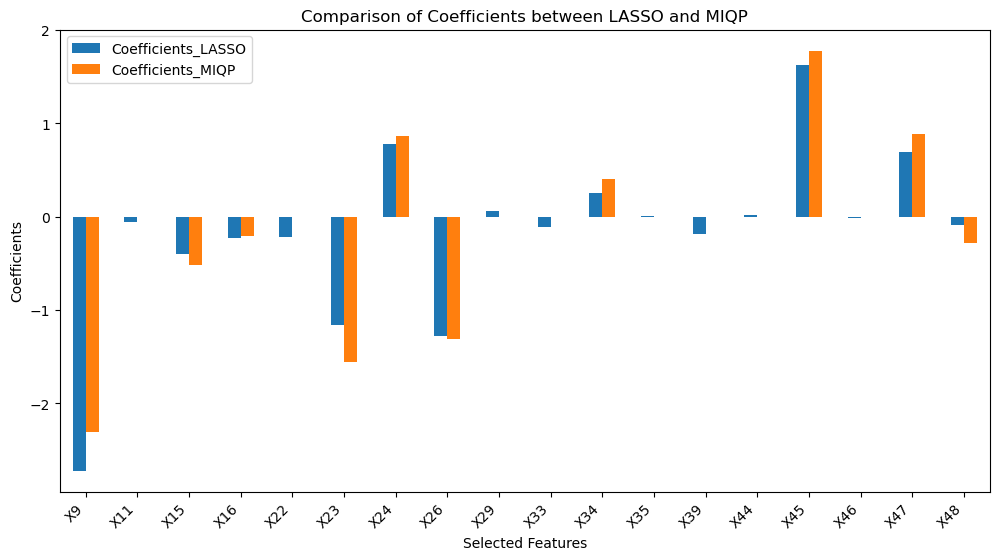

In [27]:
# Set the 'Selected Features' column as the index for better visualization
merged_df.set_index('Selected Features', inplace=True)

# Plot a bar chart with rotated x-axis labels
ax = merged_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Coefficients between LASSO and MIQP')
plt.xlabel('Selected Features')
plt.ylabel('Coefficients')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

It's noteworthy that the coefficients for the variables selected by both methods exhibit a consistent sign, indicating that they are either both positive or both negative. Furthermore, upon closer examination, a distinct pattern emerges—those coefficients identified by LASSO with values closer to zero were not chosen by the MIQP method (with the exception of X48). This divergence in feature selection highlights the nuanced differences in the regularization mechanisms employed by the two techniques.

### Comparing the actual and the predicted results of the LASSO and MIQP models

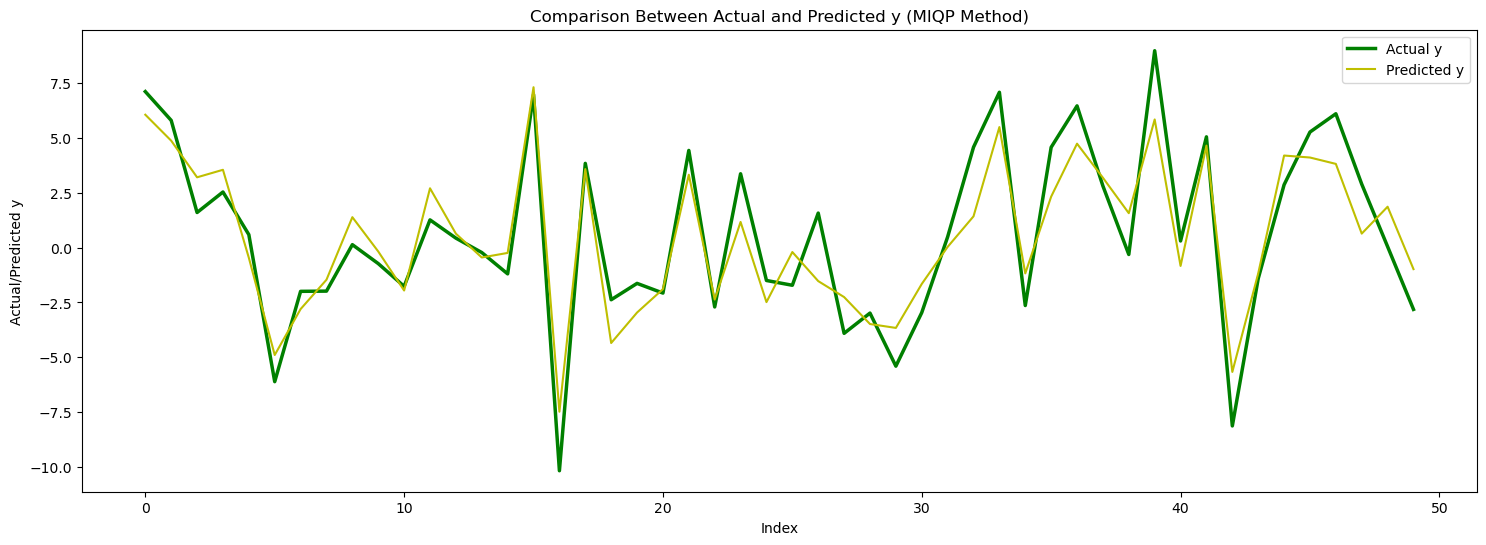

In [31]:
# Create a figure with a specified size
plt.figure(figsize=(18, 6))

# Plot the actual values in green with a label
plt.plot(Y_test.index, Y_test, color='g', label='Actual y', linewidth=2.5)

# Plot the predicted values for MIQP in yellow with a label
plt.plot(Y_test.index, y_pred, color='y', label='Predicted y')

# Add labels and title to the plot
plt.xlabel('Index')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (Lasso Method)')

# Display the legend
plt.legend()

# Show the plot
plt.show()


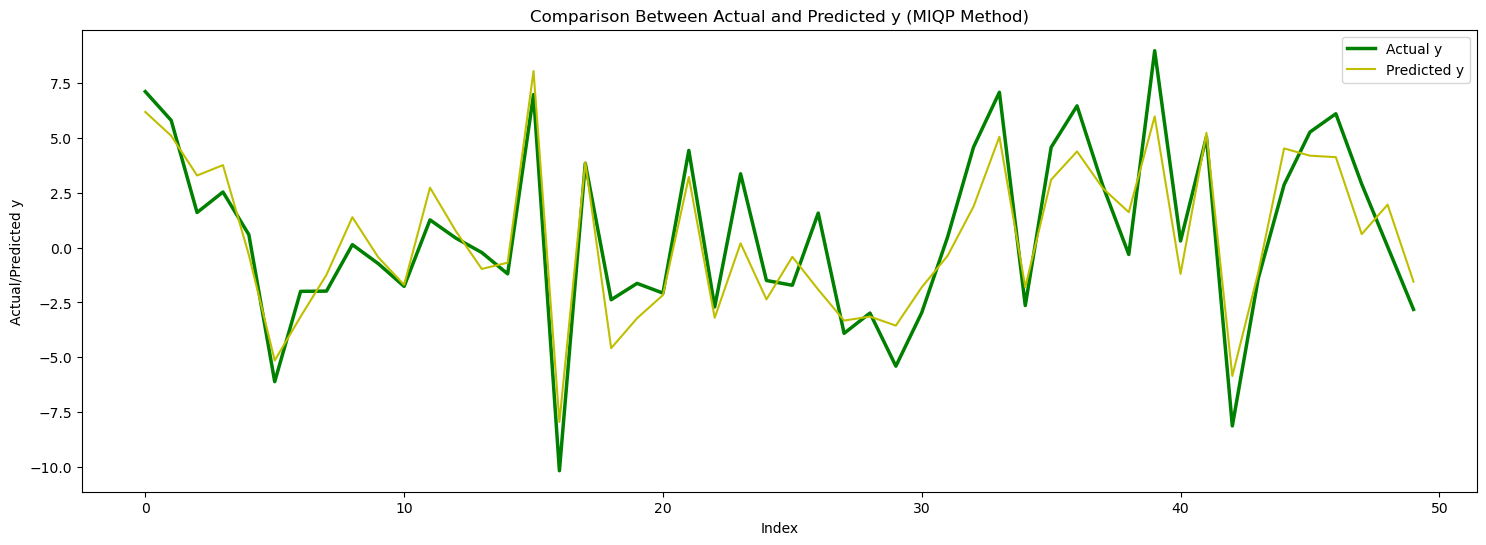

In [29]:
# Create a figure with a specified size (18 units wide, 6 units tall)
plt.figure(figsize=(18, 6))

# Plot the actual values in green with a label
plt.plot(Y_test.index, Y_test, color='g', label='Actual y', linewidth=2.5)

# Plot the predicted values for MIQP in yellow with a label
plt.plot(Y_test.index, y_pred_miqp, color='y', label='Predicted y')

# Add labels and title to the plot
plt.xlabel('Index')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (MIQP Method)')

# Display the legend
plt.legend()

# Show the plot
plt.show()


The trend suggests that both approaches behave in a similar manner. However, a closer inspection of the SSE values reveal LASSO (117.833) exhibits a slightly higher error than MIQP (116.827), resulting in a marginal difference of 1.006. While this discrepancy is minimal, it does provide MIQP with a slight performance advantage.

In [32]:
# Create a DataFrame for MIQP results
miqp_results = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted_MIQP': y_pred_miqp
})

# Create a DataFrame for LASSO results
lasso_results = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted_LASSO': y_pred
})

# Combine the results into a single DataFrame
combined_results = pd.concat([miqp_results, lasso_results], axis=1)

# Display the combined DataFrame
print("Combined Results:")
combined_results


Combined Results:


,Actual,Predicted_MIQP,Actual,Predicted_LASSO
0,7.107949,6.179859,7.107949,6.054521
1,5.796272,5.095243,5.796272,4.870655
2,1.598651,3.285595,1.598651,3.202654
3,2.532953,3.758485,2.532953,3.544853
4,0.590685,-0.332975,0.590685,-0.464032
5,-6.108818,-5.142737,-6.108818,-4.893368
6,-1.993021,-3.144544,-1.993021,-2.801400
7,-1.982904,-1.238063,-1.982904,-1.464151
8,0.134034,1.385111,0.134034,1.386181
9,-0.728690,-0.441739,-0.728690,-0.176871


In the comparative analysis of feature selection methods, it was observed that the LASSO method incorporated 18 features, in contrast to the MIQP method, which utilized a more limited set of 10 features. This distinction in the number of features used by each method is pivotal for model generalization. Generally, employing a larger number of features could increase the risk of overfitting, suggesting that MIQP's approach of using a fewer number of features might confer an advantage in terms of enhancing the model's ability to generalize to unseen data.

Furthermore, the analysis delved into the computational efficiency of each method, which is a critical factor for practical implementation of models. MIQP was noted to require a significantly larger codebase and an indeterminate period to arrive at an optimal solution. This contrasts with the LASSO method, which can be efficiently implemented using the scikit-learn package. LASSO achieves an optimal solution that is comparable to that of MIQP in terms of Sum of Squared Errors (SSE), while demanding substantially lower computational resources. This comparison underscores the efficiency and practicality of LASSO for model implementation, particularly when computational resources are a consideration.